<a href="https://colab.research.google.com/github/cassianodescovi/data-science-project/blob/main/product_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etapa 0**: Carregar pacotes e bibliotecas




In [44]:
# Importando bibliotecas necessárias para manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Função para calcular a similaridade do cosseno entre dois vetores
# Será útil para encontrar similaridades entre itens em um sistema de recomendação
from sklearn.metrics.pairwise import cosine_similarity

# Transformador TF-IDF para converter texto em uma matriz numérica
# TF-IDF é uma técnica que pondera a relevância de palavras em textos, destacando termos importantes
from sklearn.feature_extraction.text import TfidfVectorizer

# Manipulação de arquivos e criação de matrizes esparsas
# A função coo_matrix cria uma matriz esparsa que economiza memória ao armazenar apenas valores não nulos
import os
from scipy.sparse import coo_matrix


# Etapa 1: Carregamento e pré-processamento de dados:

In [45]:
# Le o conjunto de dados (substitui 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' pelo caminho do  conjunto de dados)
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [46]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


## Basic Operations

In [47]:
train_data['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4995,"Garden Mint Room Spray (Double Strength), 4 ou..."
4996,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [48]:
train_data.shape


(5000, 10)

In [49]:
train_data.isnull().sum()


,0
Uniq Id,0
Product Id,0
Product Rating,2806
Product Reviews Count,1654
Product Category,10
Product Brand,13
Product Name,0
Product Image Url,0
Product Description,1127
Product Tags,0


In [50]:
# Preencher valores ausentes na coluna 'Product Rating' com um valor padrão (por exemplo, 0)
# Isso garante que qualquer produto sem classificação seja considerado com nota 0
train_data['Product Rating'].fillna(0, inplace=True)

# Preencher valores ausentes na coluna 'Product Reviews Count' com um valor padrão (por exemplo, 0)
# Produtos sem contagem de avaliações receberão 0, evitando erros em cálculos posteriores
train_data['Product Reviews Count'].fillna(0, inplace=True)

# Preencher valores ausentes na coluna 'Product Category' com um valor padrão (por exemplo, 'Unknown')
# Quando a categoria do produto não for conhecida, será deixada como uma string vazia ('')
train_data['Product Category'].fillna('', inplace=True)

# Preencher valores ausentes na coluna 'Product Brand' com um valor padrão (por exemplo, 'Unknown')
# Isso permite evitar problemas em análises de marcas de produtos
train_data['Product Brand'].fillna('', inplace=True)

# Preencher valores ausentes na coluna 'Product Description' com uma string vazia
# Produtos sem descrição receberão uma string vazia para evitar erros ao trabalhar com textos
train_data['Product Description'].fillna('', inplace=True)


In [51]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,0


In [52]:
train_data.duplicated().sum()

0

In [54]:
# Definir um mapeamento dos nomes das colunas atuais para nomes mais curtos e simples
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}

# Renomear as colunas do DataFrame usando o mapeamento definido acima
train_data.rename(columns=column_name_mapping, inplace=True)


In [55]:
# Extrair números da coluna 'ID' e converter para float
# Isso é útil para remover caracteres indesejados e manter apenas os dígitos
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)

# Extrair números da coluna 'ProdID' e converter para float
# Assim como na coluna 'ID', isso garante que estamos lidando apenas com valores numéricos
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)


# Etapa 2: EDA (Análise Exploratória de Dados)




In [56]:
# Calcula o número de usuários únicos, com base na coluna 'ID' que representa cada usuário
num_users = train_data['ID'].nunique()

# Calcula o número de itens únicos (produtos), com base na coluna 'ProdID'
num_items = train_data['ProdID'].nunique()

# Calcula o número de classificações (ratings) únicas presentes na coluna 'Rating'
num_ratings = train_data['Rating'].nunique()

# Exibe as estatísticas básicas: número de usuários, itens e classificações
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


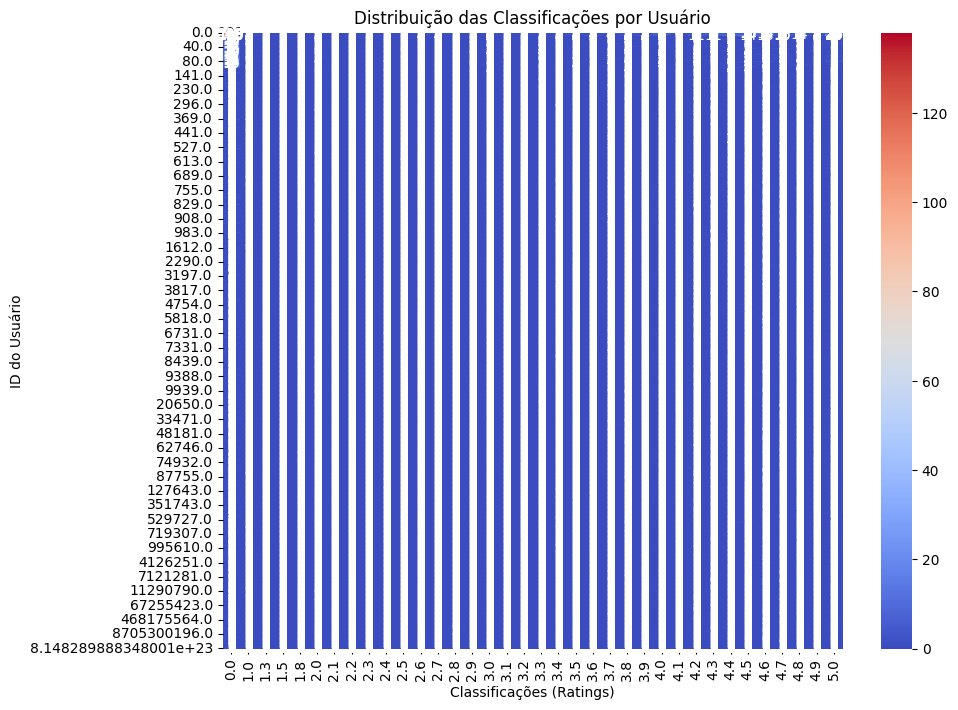

In [57]:
# Verificar se o 'ID' representa usuários únicos e 'Rating' contém valores adequados.
# e as colunas são as classificações ('Rating'), com a contagem de quantas vezes cada usuário
# deu determinada nota.

# Criando uma tabela dinâmica que conta o número de vezes que cada usuário deu cada classificação
heatmap_data = train_data.pivot_table(index='ID', columns='Rating', aggfunc='size', fill_value=0)

# Melhorando a visualização do heatmap
plt.figure(figsize=(10, 8))  # Ajustando o tamanho do gráfico
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)

# Definir o título e os rótulos dos eixos
plt.title('Distribuição das Classificações por Usuário')
plt.xlabel('Classificações (Ratings)')
plt.ylabel('ID do Usuário')

# Exibir o gráfico
plt.show()


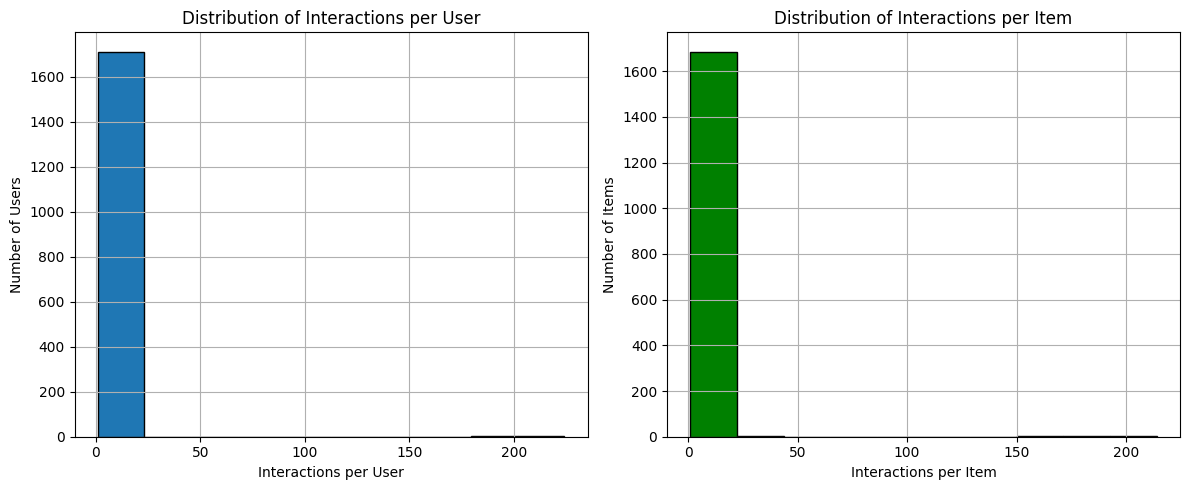

In [15]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

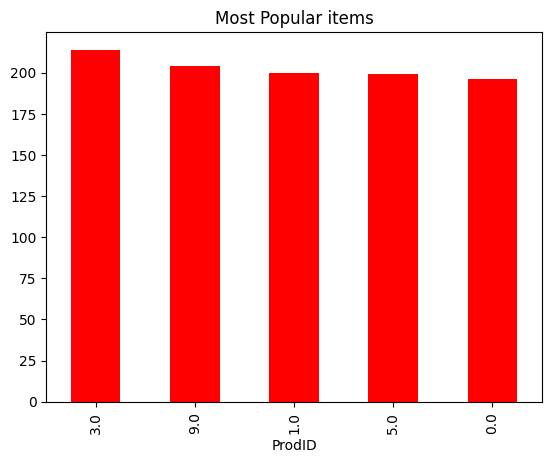

In [16]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

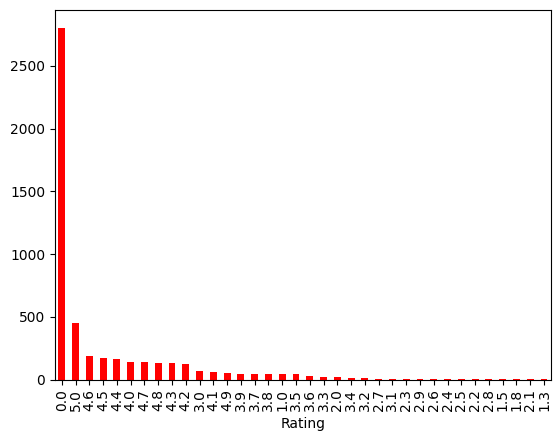

In [17]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Etapa 3: Limpeza de dados e criação de tags

In [58]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Carregar o modelo de linguagem em inglês do spacy
nlp = spacy.load("en_core_web_sm")

# Função para limpar o texto e extrair tags relevantes
def clean_and_extract_tags(text):
    """
    Limpa o texto, removendo stop words e caracteres não alfanuméricos,
    e retorna as palavras restantes como tags separadas por vírgula.
    """
    # Processar o texto para minúsculas
    doc = nlp(text.lower())

    # Extrair tokens que são alfanuméricos e não são stop words
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]

    # Retornar as tags separadas por vírgula
    return ', '.join(tags)

# Colunas onde as tags serão extraídas
columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

# Aplicar a função de limpeza e extração de tags em cada coluna
for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

# Agora, as colunas 'Category', 'Brand' e 'Description' têm texto limpo com tags extraídas.


In [59]:
# Concatenar as tags limpas das colunas 'Category', 'Brand', e 'Description' em uma nova coluna 'Tags'
# Para cada linha, junta as tags de todas as colunas relevantes em uma string, separada por vírgula
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Agora, a coluna 'Tags' contém todas as tags concatenadas, extraídas das colunas especificadas.

# Sistema de Recomendações de Base de Classificação

In [60]:

# Agrupar os produtos pelas colunas 'Name', 'ReviewCount', 'Brand' e 'ImageURL',
# e calcular a média das classificações ('Rating') para cada grupo.
average_ratings = train_data.groupby(['Name', 'ReviewCount', 'Brand', 'ImageURL'])['Rating'].mean().reset_index()

# O resultado será um DataFrame onde cada linha representa um produto com o nome, contagem de avaliações, marca,
# URL da imagem e a média de classificações calculada para esse produto.


In [61]:
# Ordenar os produtos pela média de classificação de forma decrescente (do maior para o menor)
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

# Selecionar os 10 produtos mais bem avaliados como base para o sistema de recomendação
rating_base_recommendation = top_rated_items.head(10)

# O DataFrame 'rating_base_recommendation' agora contém os 10 produtos com as melhores médias de classificação,
# prontos para serem recomendados.


In [62]:
# Converter a coluna 'Rating' para o tipo inteiro, removendo os decimais
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)

# Converter a coluna 'ReviewCount' para o tipo inteiro, pois a contagem de avaliações deve ser um número inteiro
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

# Agora as colunas 'Rating' e 'ReviewCount' estão com valores inteiros.


<ipython-input-62-197db6d7538a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
<ipython-input-62-197db6d7538a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [23]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


<ipython-input-23-6e413a8a573d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2,"gold, bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1,"red, devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1,"air, wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,"bain, de, terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12,"long, aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5


# Sistema de recomendação baseado em conteúdo (preferências do usuário ou similaridades de itens)*

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Criar um vetor TF-IDF com base nas tags dos produtos, removendo stop words em inglês
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Ajustar o vetor TF-IDF no campo 'Tags' e transformá-lo em uma matriz numérica
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

# Calcular a similaridade do cosseno entre todos os produtos com base nas suas tags
cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

# 'cosine_similarities_content' agora contém as similaridades entre cada par de produtos,
# que podem ser usadas para recomendar produtos semelhantes.


In [25]:
# Nome do produto para o qual queremos encontrar produtos semelhantes
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

# Encontrar o índice do produto com o nome especificado no DataFrame
item_index = train_data[train_data['Name'] == item_name].index[0]

# Agora, 'item_index' contém o índice do produto no DataFrame, que será usado para encontrar produtos semelhantes.


In [26]:
# Gerar uma lista de itens semelhantes, onde cada tupla contém o índice do produto e sua similaridade com o item original
similar_items = list(enumerate(cosine_similarities_content[item_index]))

# Agora, 'similar_items' contém uma lista de pares (índice, similaridade) que indicam a similaridade entre o item escolhido e os demais itens no dataset.



In [64]:
# Ordenar a lista de itens semelhantes pela pontuação de similaridade em ordem decrescente
similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

# Selecionar os 9 itens mais semelhantes ao produto original (excluindo o próprio produto)
top_similar_items = similar_items[1:10]  # Ignorar o item no índice 0, que é o próprio item

# Extrair os índices dos itens recomendados (os itens mais semelhantes)
recommended_items_indics = [x[0] for x in top_similar_items]

# 'recommended_items_indics' agora contém os índices dos produtos recomendados, prontos para serem recuperados do DataFrame


In [28]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


# Função para recomendar produtos para base de conteúdo

In [65]:
def content_based_recommendations(train_data, item_name, top_n=10):
    # Verifique se o nome do item existe nos dados de treino
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' não encontrado nos dados de treino.")
        return pd.DataFrame()

    # Crie um vetorizador TF-IDF para as descrições dos itens
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Aplique a vetorização TF-IDF nas descrições dos itens
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calcule a similaridade do cosseno entre os itens com base nas descrições
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Encontre o índice do item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Obtenha as pontuações de similaridade do cosseno para o item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Ordene os itens semelhantes pela pontuação de similaridade em ordem decrescente
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Obtenha os N itens mais semelhantes (excluindo o próprio item)
    top_similar_items = similar_items[1:top_n+1]

    # Obtenha os índices dos itens mais semelhantes
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Obtenha os detalhes dos itens mais semelhantes
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details


In [66]:
# Exemplo: Obtenha recomendações baseadas em conteúdo para um item específico
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [67]:
# Exemplo: Obtenha recomendações baseadas em conteúdo para um item específico
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


# Filtragem colaborativa (similaridade de itens do usuário)

In [68]:
# Criar uma matriz de usuários e itens (linhas são IDs de usuários e colunas são IDs de produtos)
# O valor da célula é a classificação média que o usuário deu ao produto, preenchendo com 0 se não houver avaliação
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0).astype(int)

In [69]:
# Calcular a similaridade entre os usuários com base na matriz de itens avaliados
user_similarity = cosine_similarity(user_item_matrix)


In [70]:
# Definir o ID do usuário-alvo para o qual queremos fazer recomendações
target_user_id = 4

# Obter o índice do usuário-alvo na matriz de usuários
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [36]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [71]:
# Iterar sobre os usuários mais semelhantes
for user_index in similar_user_indices:
    # Obter os itens avaliados pelo usuário semelhante
    rated_by_similar_user = user_item_matrix.iloc[user_index]

    # Identificar itens que o usuário-alvo ainda não avaliou, mas que foram avaliados pelo usuário semelhante
    not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

    # Adicionar esses itens à lista de recomendações (limitando a 10 itens por usuário semelhante)
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

# Obter os detalhes dos itens recomendados
recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

In [72]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul, sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,"ag, hair",https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


# Função que recomenda itens

In [73]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Criar a matriz de usuários e itens (linhas são IDs de usuários e colunas são IDs de produtos)
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calcular a matriz de similaridade entre os usuários usando a similaridade do cosseno
    user_similarity = cosine_similarity(user_item_matrix)

    # Encontrar o índice do usuário-alvo na matriz de usuários
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Obter as pontuações de similaridade para o usuário-alvo
    user_similarities = user_similarity[target_user_index]

    # Ordenar os usuários por similaridade em ordem decrescente (excluindo o próprio usuário)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Gerar recomendações com base nos usuários semelhantes
    recommended_items = []

    for user_index in similar_users_indices:
        # Obter os itens avaliados pelo usuário semelhante, mas não pelo usuário-alvo
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extrair os IDs dos itens recomendados e adicionar à lista de recomendações
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Obter os detalhes dos itens recomendados
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    # Retornar os detalhes dos itens recomendados (limitado ao top 10)
    return recommended_items_details.head(10)

# Exemplo de uso
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec


Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


# Hybrid Recommendations

In [74]:
# Recomendações Híbridas (Combinando Baseado em Conteúdo e Filtragem Colaborativa)
def hybrid_recommendations(train_data, target_user_id, item_name, top_n=10):
    # Obter recomendações baseadas em conteúdo
    content_based_rec = content_based_recommendations(train_data, item_name, top_n)

    # Obter recomendações de filtragem colaborativa
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id, top_n)

    # Combinar e remover duplicatas das recomendações
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    # Retornar as 10 principais recomendações híbridas
    return hybrid_rec.head(10)


In [75]:
# Exemplo de uso: Obtenha recomendações híbridas para um usuário e item específicos
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [42]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0
